Background Removal with Robust PCA

In [1]:
from glob import glob
import sys, os
import numpy as np
import scipy
%matplotlib inline
import matplotlib.pyplot as plt
# MAX_ITERS = 10
TOL = 1.0e-8

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:

# load and show an image with Pillow
from PIL import Image
# load the image
image1 = Image.open('/content/drive/My Drive/jk3.png')
# summarize some details about the image
print(image1.format)
print(image1.mode)
print(image1.size)


PNG
RGB
(640, 972)


float32
(972, 640, 3)


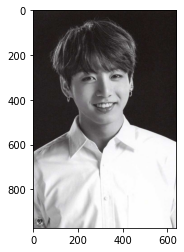

In [31]:
from matplotlib import image
from matplotlib import pyplot
# load image as pixel array
data = image.imread('/content/drive/My Drive/jk3.png')
# summarize shape of the pixel array
print(data.dtype)
print(data.shape)
# display the array of pixels as an image
pyplot.imshow(data)
pyplot.show()

In [16]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def plt_images(M, A, E, index_array, dims, filename=None):
    f = plt.figure(figsize=(15, 10))
    r = len(index_array)
    pics = r * 3
    for k, i in enumerate(index_array):
        for j, mat in enumerate([M, A, E]):
            sp = f.add_subplot(r, 3, 3*k + j + 1)
            sp.axis('Off')
            pixels = mat[:,i]
            if isinstance(pixels, scipy.sparse.csr_matrix):
                pixels = pixels.todense()
            plt.imshow(np.reshape(pixels, dims), cmap='gray')
    return f
    
def plots(ims, dims, figsize=(15,20), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims)
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        plt.imshow(np.reshape(ims[i], dims), cmap="gray")

In [22]:
#scale = 25   # Adjust scale to change resolution of image
#dims = (int(240 * (scale/100)), int(320 * (scale/100)))

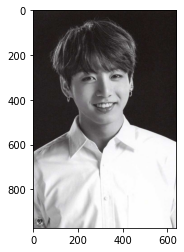

In [32]:
plt.imshow(data, cmap='gray');

uint8
(779, 1200)


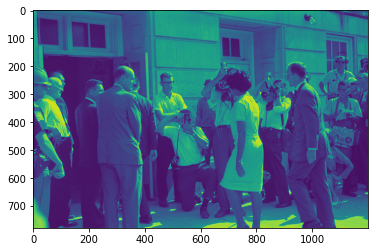

In [30]:

# load image as pixel array
data1 = image.imread('/content/drive/My Drive/city.jpg')
# summarize shape of the pixel array
print(data1.dtype)
print(data1.shape)
# display the array of pixels as an image
pyplot.imshow(data1)
pyplot.show()

In [39]:
plt.imsave("/content/drive/My Drive/jk4.png" , data, cmap='gray')
plt.imsave("/content/drive/My Drive/city2.jpg" ,  data1, cmap='gray')

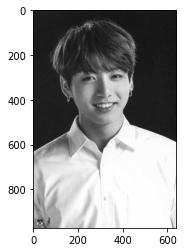

In [53]:
rgb_weights = [0.2989, 0.5870, 0.1140]

grayscale_image1 = np.dot(data[...,:3], rgb_weights)
pyplot.imshow(grayscale_image1, cmap=pyplot.get_cmap("gray"))

In [54]:
print(grayscale_image1.dtype)
print(grayscale_image1.shape)


float64
(972, 640)


In [56]:
print(data1.dtype)
print(data1.shape)

uint8
(779, 1200)


In [66]:
#A first attempt with SVD

from sklearn import decomposition
u, s, v = decomposition.randomized_svd(grayscale_image1, 2)
u.shape, s.shape, v.shape

((972, 2), (2,), (2, 640))

In [65]:
#A first attempt with SVD

from sklearn import decomposition
u1, s1, v1 = decomposition.randomized_svd(data1, 2)
u1.shape, s1.shape, v1.shape

((779, 2), (2,), (2, 1200))

In [70]:
low_rank = u @ np.diag(s) @ v

In [69]:
low_rank1 = u1 @ np.diag(s1) @ v1

In [71]:
low_rank.shape

(972, 640)

In [73]:
low_rank1.shape

(779, 1200)

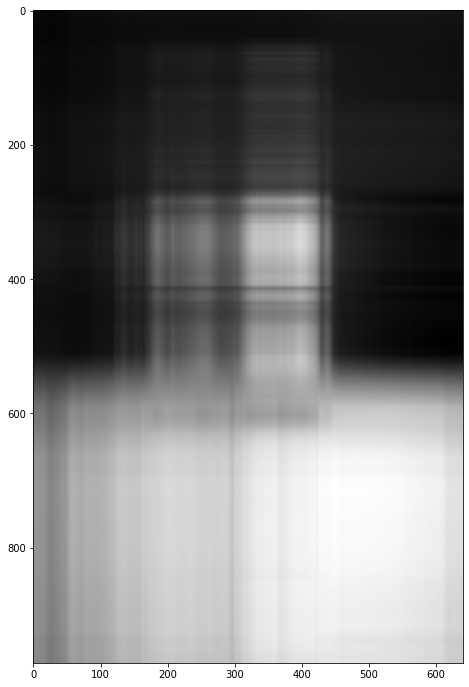

In [74]:
plt.figure(figsize=(12, 12))
plt.imshow(low_rank, cmap='gray')

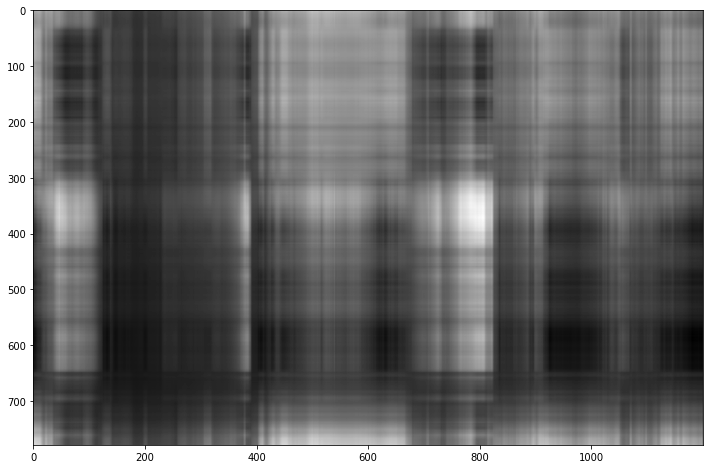

In [75]:
plt.figure(figsize=(12, 12))
plt.imshow(low_rank1, cmap='gray')

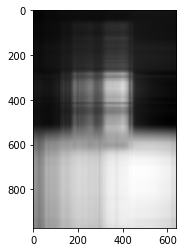

In [79]:
#The below images were created with high-res data. Very slow to process:

plt.imshow(low_rank, cmap='gray');

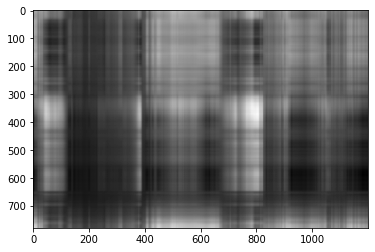

In [80]:
#The below images were created with high-res data. Very slow to process:

plt.imshow(low_rank1, cmap='gray');

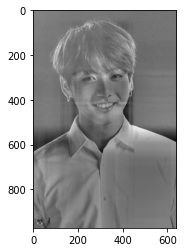

In [83]:
plt.imshow(grayscale_image1 - low_rank, cmap='gray');

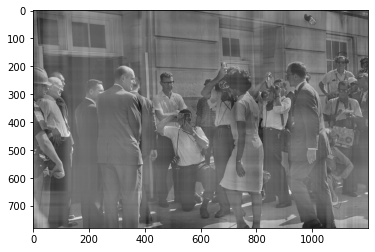

In [84]:
plt.imshow(data1 - low_rank1, cmap='gray');

In [85]:
#Rank 1 Approximation

u, s, v = decomposition.randomized_svd(grayscale_image1, 1)
u1, s1, v1 = decomposition.randomized_svd(data1, 1)

In [86]:
u1.shape, s1.shape, v1.shape

((779, 1), (1,), (1, 1200))

In [87]:
u.shape, s.shape, v.shape

((972, 1), (1,), (1, 640))

In [88]:
low_rank = u @ np.diag(s) @ v
low_rank.shape

(972, 640)

In [89]:
low_rank1 = u1 @ np.diag(s) @ v1
low_rank1.shape

(779, 1200)

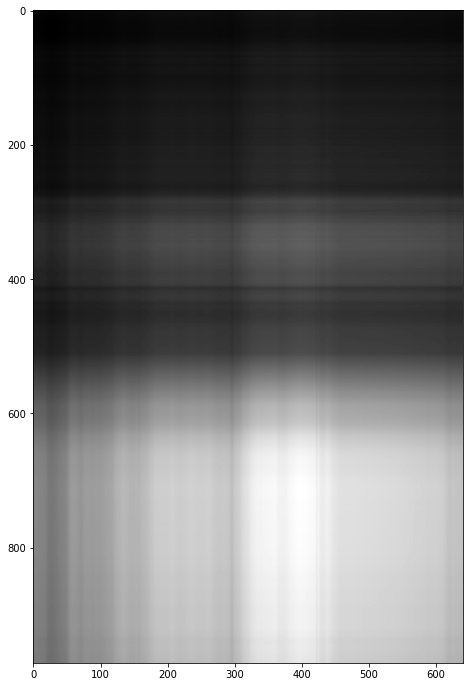

In [90]:
plt.figure(figsize=(12, 12))
plt.imshow(low_rank, cmap='gray')

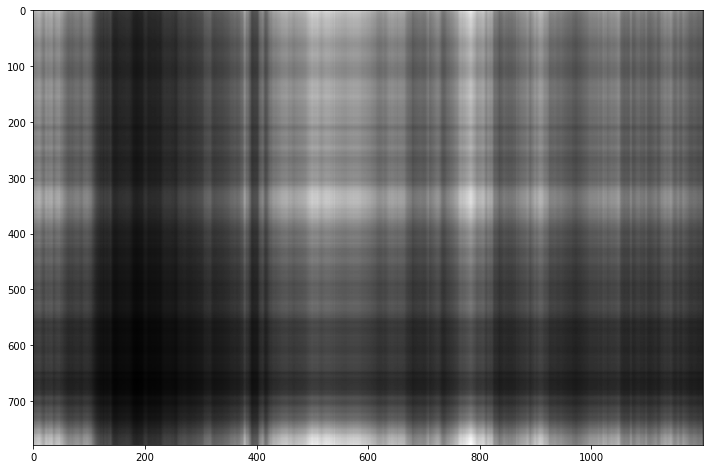

In [91]:
plt.figure(figsize=(12, 12))
plt.imshow(low_rank1, cmap='gray')

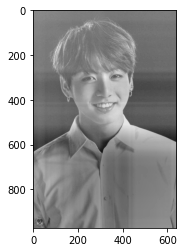

In [94]:
plt.imshow(grayscale_image1 - low_rank,cmap='gray');

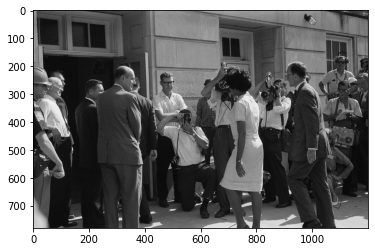

In [95]:
plt.imshow(data1 - low_rank1,cmap='gray');

Robust PCA (via Primary Component Pursuit)

In [ ]:
from scipy import sparse
from sklearn.utils.extmath import randomized_svd
import fbpca
TOL=1e-9
MAX_ITERS=3
def converged(Z, d_norm):
    err = np.linalg.norm(Z, 'fro') / d_norm
    print('error: ', err)
    return err < TOL
def shrink(M, tau):
    S = np.abs(M) - tau
    return np.sign(M) * np.where(S>0, S, 0)
def _svd(M, rank): return fbpca.pca(M, k=min(rank, np.min(M.shape)), raw=True)
def norm_op(M): return _svd(M, 1)[1][0]
def svd_reconstruct(M, rank, min_sv):
    u, s, v = _svd(M, rank)
    s -= min_sv
    nnz = (s > 0).sum()
    return u[:,:nnz] @ np.diag(s[:nnz]) @ v[:nnz], nnz
def pcp(X, maxiter=10, k=10): # refactored
    m, n = X.shape
    trans = m<n
    if trans: X = X.T; m, n = X.shape
        
    lamda = 1/np.sqrt(m)
    op_norm = norm_op(X)
    Y = np.copy(X) / max(op_norm, np.linalg.norm( X, np.inf) / lamda)
    mu = k*1.25/op_norm; mu_bar = mu * 1e7; rho = k * 1.5
    
    d_norm = np.linalg.norm(X, 'fro')
    L = np.zeros_like(X); sv = 1
    
    examples = []
    
    for i in range(maxiter):
        print("rank sv:", sv)
        X2 = X + Y/mu
        
        # update estimate of Sparse Matrix by "shrinking/truncating": original - low-rank
        S = shrink(X2 - L, lamda/mu)
        
        # update estimate of Low-rank Matrix by doing truncated SVD of rank sv & reconstructing.
        # count of singular values > 1/mu is returned as svp
        L, svp = svd_reconstruct(X2 - S, sv, 1/mu)
        
        # If svp < sv, you are already calculating enough singular values.
        # If not, add 20% (in this case 240) to sv
        sv = svp + (1 if svp < sv else round(0.05*n))
        
        # residual
        Z = X - L - S
        Y += mu*Z; mu *= rho
        
        examples.extend([S[140,:], L[140,:]])
        
        if m > mu_bar: m = mu_bar
        if converged(Z, d_norm): break
    
    if trans: L=L.T; S=S.T
    return L, S, examples

In [ ]:
m, n = M.shape
round(m * .05)


In [ ]:
L, S, examples =  pcp(M, maxiter=5, k=10)

In [ ]:
plots(examples, dims, rows=5)

In [ ]:
f = plt_images(M, S, L, [140], dims)

In [ ]:
np.save("high_res_L.npy", L)
np.save("high_res_S.npy", S)
f = plt_images(M, S, L, [0, 100, 1000], dims)